# Hello, FABRIC: Create your first FABRIC slice

## Configure the Environment

Set the environment variable that will be used by this notebook. If you are using the FABRIC, JupyterHub some of the environment will be automatically configured for you.  You will only need to set your bastion username, upload your bastion private key, and set the path to where you put your bastion private key. Your bastion username and private key should already be in your possession.  If you do not have a bastion username and private key, please contact the FABRIC admins using the [FABRIC User Forum](https://learn.fabric-testbed.net/forums/) 

If you are using the FABRIC API outside of the JupyterHub you will need to configure all of the environment variables. Defaults below will be correct in many situations but you will need to confirm your configuration.  If you have questions about this configuration, please contact the FABRIC admins using the [FABRIC User Forum](https://learn.fabric-testbed.net/forums/) 

More information about accessing your experiments through the FABRIC bastion hosts can be found [here](https://learn.fabric-testbed.net/knowledge-base/logging-into-fabric-vms/).

#### Configure the Experiment Parameters



In [1]:
slice_name_base = 'MySlice_Components_Test'
#test_sites = [ 'UKY', 'RENC', 'LBNL' ]
#test_sites = [ 'TACC', 'MAX', 'UTAH', 'NCSA', 'MICH', 'WASH', 'DALL', 'SALT', 'STAR']
test_sites = [ 'MICH' ]

node_name_base = 'node'
#image = 'default_centos_8'
image = 'default_ubuntu_20'
#image = 'default_rocky_8'
cores = 2
ram = 8
disk = 10

vlan = None
run_non_net_tests=True
basic_node_count=2

#vlan = '1234'
#run_non_net_tests=False
#basic_node_count=0

worker_id = None
#worker_id = 'star-w6.fabric-testbed.net' 

In [3]:
import os

# If you are using the FABRIC JupyterHub, the following three evnrionment vars
# were automatically provided when you logged in.
#os.environ['FABRIC_CREDMGR_HOST']='cm.fabric-testbed.net'
#os.environ['FABRIC_ORCHESTRATOR_HOST']='orchestrator.fabric-testbed.net'
#os.environ['FABRIC_TOKEN_LOCATION']=os.environ['HOME']+'/work/fabric_token.json'

# Bastion IPs
os.environ['FABRIC_BASTION_HOST'] = 'bastion-1.fabric-testbed.net'

# Set your Bastion username and private key
os.environ['FABRIC_BASTION_USERNAME']='pruth_0031379841'
os.environ['FABRIC_BASTION_KEY_LOCATION']=os.environ['HOME']+'/work/.ssh/id_rsa_fabric'

# Set the keypair FABRIC will install in your slice. 
os.environ['FABRIC_SLICE_PRIVATE_KEY_FILE']=os.environ['HOME']+'/.ssh/id_rsa'
os.environ['FABRIC_SLICE_PUBLIC_KEY_FILE']=os.environ['HOME']+'/.ssh/id_rsa.pub'

# If your slice private key uses a passphrase, set the passphrase
#from getpass import getpass
#print('Please input private key passphrase. Press enter for no passphrase.')
#os.environ['FABRIC_SLICE_PRIVATE_KEY_PASSPHRASE']=getpass()

## Setup the Experiment

#### Import the FABRIC API

In [4]:
import json
import traceback
from fabrictestbed_extensions.fablib.fablib import fablib

#### Create the FABRIC Proxies

The FABRIC API is used via proxy objects that manage connections to the control framework.  

#### (Optional) Query Available Resources

This optional command queries the FABRIC services to find the available resources. It may be useful for finding a site with available capacity.

Available Resources: TACC [Site] : { cpu: 10/10 , core: 320/320 , ram: 2,560/2,560 G, disk: 116,400/116,400 G, unit: 5/5 }
	Components:
		NVME-P4510:  NVME P4510 { disk: 15,360/15,360 G, unit: 16/16 }
		GPU-RTX6000:  GPU RTX6000 { unit: 6/6 }
		GPU-Tesla T4:  GPU Tesla T4 { unit: 4/4 }
		SharedNIC-ConnectX-6:  SharedNIC ConnectX-6 { unit: 635/635 }
		SmartNIC-ConnectX-6:  SmartNIC ConnectX-6 { unit: 2/2 }
		SmartNIC-ConnectX-5:  SmartNIC ConnectX-5 { unit: 4/4 }
	Site Interfaces:
		TACC_DALL: TrunkPort { bw: 100/100 Gbps}
UTAH [Site] : { cpu: 10/10 , core: 320/320 , ram: 2,560/2,560 G, disk: 116,400/116,400 G, unit: 5/5 }
	Components:
		SmartNIC-ConnectX-5:  SmartNIC ConnectX-5 { unit: 4/4 }
		NVME-P4510:  NVME P4510 { disk: 15,360/15,360 G, unit: 16/16 }
		SharedNIC-ConnectX-6:  SharedNIC ConnectX-6 { unit: 635/635 }
		GPU-RTX6000:  GPU RTX6000 { unit: 5/5 }
		GPU-Tesla T4:  GPU Tesla T4 { unit: 4/4 }
		SmartNIC-ConnectX-6:  SmartNIC ConnectX-6 { unit: 2/2 }
	Site Interfaces:
		UTAH_S

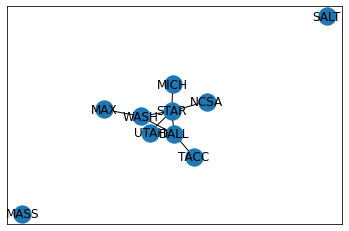

In [5]:
try:
    available_resources = fablib.get_available_resources()
    print(f"Available Resources: {available_resources}")
    available_resources.draw()
except Exception as e:
    print(f"Error: {e}")
    traceback.print_exc()

## Create the Experiment Slice

Load aggragate ads.

In [6]:
import glob
import json

#aggregate_json_dir=os.environ['HOME']+"/work/git/jupyter-examples/fabric_examples/testing_and_debugging/aggregates/"
aggregate_json_dir="./aggregates/"

aggregates = {}
aggregate_files = glob.glob(aggregate_json_dir+"*.json")
for file_name in aggregate_files:
    print(f"Reading {file_name}")
    site_name = file_name.replace(aggregate_json_dir,"",1).split(".")[0]
    #print(f"{site_name}")
    with open(file_name, 'r') as infile:
        site_info = json.load(infile)
    #print(f"{site_json}")
    aggregates[site_name] = site_info
    
    
    
if worker_id:    
    # Hack to remove most workers and test only one
    site_info = aggregates[test_sites[0]]
    print(f"worker_id: {worker_id}")
    target_worker_info = {}
    for worker in site_info['Nodes']:
        #print(f"site_info: {site_info}")
        #print(f"worker['Name'] = {worker['Name']}")
        if worker['Name'] == worker_id:
            print(f"worker['Name'] = {worker['Name']}")
            target_worker_info = worker
            break

    site_info['Nodes'] = [ worker ]

    site_info = aggregates[test_sites[0]]


    print(json.dumps(site_info['Nodes'], indent=4, sort_keys=True))


Reading ./aggregates/RENC.json
Reading ./aggregates/TACC.json
Reading ./aggregates/MAX.json
Reading ./aggregates/LBNL.json
Reading ./aggregates/NCSA.json
Reading ./aggregates/UTAH.json
Reading ./aggregates/UKY.json
Reading ./aggregates/SALT.json
Reading ./aggregates/MICH.json
Reading ./aggregates/STAR.json
Reading ./aggregates/DALL.json
Reading ./aggregates/WASH.json


### Create Slice

<img src="./figs/SingleNode.png" width="20%"><br>

Create a single node with basic compute capabilities. The submit function will block until the node is ready and will display a progress bar.


In [7]:
slice_name=f"{slice_name_base}"
print(f"Creating slice {slice_name}")

networks = []

try:
    slice = fablib.new_slice(slice_name)
    for site in test_sites:
        print(f"{site}")
        site_info = aggregates[site]
        
        net1_ifaces = []
        net2_ifaces = []
        netBasic_ifaces = []
            
        for node_info in site_info['Nodes']:
            print(f"{node_info['Name']}")
            worker = node_info['Name']
            worker_short_name = worker.split(".")[0]
            print(f"slice name: {worker}")
            node_num = 0
            
            for basicNode in range(basic_node_count):
                node_num += 1

                node_name = f"{node_name_base}_{worker_short_name}_{node_num}_BASIC"
                # Add node
                node = slice.add_node(name=node_name, site=site)
                node.set_capacities(cores=cores, ram=ram, disk=disk)
                node.set_image(image)
                node.set_host(worker)
                
                [iface1] = node.add_component(model="NIC_Basic", name=node_name).get_interfaces()
                netBasic_ifaces.append(iface1)

            skipped_first_cx6 = False
            skipped_first_cx5 = False
            cx6_count = 0
            cx5_count = 0
            for component_info in node_info['Components']:
                if not run_non_net_tests and component_info['Type'] != "EthernetCardPF":
                    print(f"Skipping component: {component_info['Type']} - {component_info['Model']}")
                    continue
                
                
                if not skipped_first_cx6 and component_info['Model'] == 'ConnectX-6':
                    skipped_first_cx6 = True
                    continue

                if cx6_count == 0 and component_info['Model'] == 'ConnectX-6':
                    cx6_count += 1
                    continue
            
                if cx5_count == 0 and component_info['Model'] == 'ConnectX-5':
                    cx5_count += 1
                    continue
                    
                node_num += 1

                node_name = f"{node_name_base}_{worker_short_name}_{node_num}_{component_info['Model'].replace(' ','').replace('/','-')}"
                # Add node
                node = slice.add_node(name=node_name, site=site)
                node.set_capacities(cores=cores, ram=ram, disk=disk)
                node.set_image(image)
                node.set_host(worker)


                # NIC_Basic 
                # NIC_ConnectX_6
                # NIC_ConnectX_5
                # NVME_P4510
                # GPU_TeslaT4
                # GPU_RTX6000
                fablib_compenent_model = None
                if component_info['Type'] == "EthernetCardPF" and component_info['Model'] == "ConnectX-6":
                    fablib_compenent_model = 'NIC_ConnectX_6'
                    cx6_count = 0
                    [iface1,iface2] = node.add_component(model=fablib_compenent_model, name=f"{node_name}_{fablib_compenent_model}").get_interfaces()
                    if vlan:
                        iface1.set_vlan(vlan=vlan)
                        iface2.set_vlan(vlan=vlan)
                    net1_ifaces.append(iface1)
                    net2_ifaces.append(iface2)
                    
                elif component_info['Type'] == "EthernetCardPF" and component_info['Model'] == "ConnectX-5":
                    fablib_compenent_model = 'NIC_ConnectX_5'
                    cx5_count = 0
                    [iface1,iface2] = node.add_component(model=fablib_compenent_model, name=f"{node_name}_{fablib_compenent_model}").get_interfaces()
                    if vlan:
                        iface1.set_vlan(vlan=vlan)
                        iface2.set_vlan(vlan=vlan)
                    net1_ifaces.append(iface1)
                    net2_ifaces.append(iface2)
                elif component_info['Type'] == "NVMe" and component_info['Model'] == "P4510":
                    fablib_compenent_model = 'NVME_P4510'
                    node.add_component(model=fablib_compenent_model, name=f"{node_name}_{fablib_compenent_model}")
                elif component_info['Type'] == "GPU" and component_info['Model'] == "Tesla T4":
                    fablib_compenent_model = 'GPU_TeslaT4'
                    node.add_component(model=fablib_compenent_model, name=f"{node_name}_{fablib_compenent_model}")
                elif component_info['Type'] == "GPU" and component_info['Model'] == "Quadro RTX 6000/8000":
                    fablib_compenent_model = 'GPU_RTX6000'
                    node.add_component(model=fablib_compenent_model, name=f"{node_name}_{fablib_compenent_model}")
                else:
                    print(f"Sould not Get Here: Skipping component: {component_info['Type']} - {component_info['Model']}")

    
        #Add networks
        if len(net1_ifaces) > 1:
            net1 = slice.add_l2network(name=f'{site}_net1', interfaces=net1_ifaces)
            networks.append({ net1.get_name(): net1_ifaces })
            pass
        else:
            print(f"Skipping net1_ifaces. len(net1_ifaces) = {len(net1_ifaces)}")
            
        if len(net2_ifaces) > 1:
            net2 = slice.add_l2network(name=f'{site}_net2', interfaces=net2_ifaces)
            networks.append({ net2.get_name(): net2_ifaces })
            pass
        else:
            print(f"Skipping net1_ifaces. len(net2_ifaces) = {len(net2_ifaces)}")
            
        if len(netBasic_ifaces) > 1:
            netBasic_ifaces = slice.add_l2network(name=f'{site}_netBasic_ifaces', interfaces=netBasic_ifaces)
            networks.append({ netBasic_ifaces.get_name(): netBasic_ifaces })
            pass

        else:
            print(f"Skipping net1_ifaces. len(netBasic_ifaces) = {len(netBasic_ifaces)}")
            
        

    #Submit Slice Request
    slice.submit(wait_progress=False)
except Exception as e:
    print(f"Slice Failed: {e}")
    traceback.print_exc()


Creating slice MySlice_Components_Test
MICH
mich-w1.fabric-testbed.net
slice name: mich-w1.fabric-testbed.net
mich-w2.fabric-testbed.net
slice name: mich-w2.fabric-testbed.net
mich-w3.fabric-testbed.net
slice name: mich-w3.fabric-testbed.net


In [8]:
import time

slice_name=f"{slice_name_base}"
            
try:
    print(f"Waiting for slice {slice_name} ")

    #Get Slice
    slice = fablib.get_slice(slice_name)

    #Wait for ssh to be active
    slice.wait_ssh(progress=True, timeout=600,interval=60)
    #time.sleep(30)
    
    #Run post boo config
    slice.post_boot_config(verbose=False)
except Exception as e:
    print(f"Slice Failed: {e}")
    traceback.print_exc()

Waiting for slice MySlice_Components_Test 
Running fablib.get_slice_manager().slices(): elapsed time: 0.04196000099182129 seconds
Waiting for slice ..

KeyboardInterrupt: 

In [ ]:
slice_name=f"{slice_name_base}"
            
try:
    print(f"Waiting for slice {slice_name} ")
    print(json.dumps(slice.get_interface_map(), indent=4, sort_keys=True))
except:
    print("Error")

### Print the Node's Attributes

Each node in the slice has a set of get functions that return the node's attributes.

In [ ]:
slice_name=f"{slice_name_base}"
print(f"Getting slice {slice_name} ")
try: 
    slice = fablib.get_slice(slice_name)
 
    for node in slice.get_nodes():
        print("Node:")
        print(f"   Name              : {node.get_name()}")
        print(f"   Cores             : {node.get_cores()}")
        print(f"   RAM               : {node.get_ram()}")
        print(f"   Disk              : {node.get_disk()}")
        print(f"   Image             : {node.get_image()}")
        print(f"   Image Type        : {node.get_image_type()}")
        print(f"   Host              : {node.get_host()}")
        print(f"   Site              : {node.get_site()}")
        print(f"   Management IP     : {node.get_management_ip()}")
        print(f"   Reservation ID    : {node.get_reservation_id()}")
        print(f"   Reservation State : {node.get_reservation_state()}")
        print(f"   SSH Command       : {node.get_ssh_command()}")
        print(f"   SSH Test Result   : {node.test_ssh()}")


        for component in node.get_components():
            print(f"      Name             : {component.get_name()}")
            print(f"      Details          : {component.get_details()}")
            print(f"      Disk (G)         : {component.get_disk()}")
            print(f"      Units            : {component.get_unit()}")
            print(f"      PCI Address      : {component.get_pci_addr()}")
            print(f"      Model            : {component.get_model()}")
            print(f"      Type             : {component.get_type()}") 
        print(f"   Interfaces        :  ")
        for interface in node.get_interfaces():
            print(f"       Name                : {interface.get_name()}")
            print(f"           Bandwidth           : {interface.get_bandwidth()}")
            print(f"           VLAN                : {interface.get_vlan()}")       
            print(f"           OS Interface        : {interface.get_os_interface()}")       

        print()    
except Exception as e:
    print(f"Fail: {e}")

### Test SSH

In [ ]:
slice_name=f"{slice_name_base}"
print(f"Getting slice {slice_name} ")
try: 
    slice = fablib.get_slice(slice_name)
    for node in slice.get_nodes():
        print(f"Node: {node.get_name()}, Host: {node.get_host()}, SSH Test: {node.test_ssh()}")
        
except Exception as e:
    print(f"Fail: {e}")

## Accessing the VM


#### SSH with fablib

Most experiments will require automated configuration and execution. You can use the fablib library to execute arbitrary commands on your node. 

The following code demonstrates how to use fablib to execute a "Hello, FABRIC" bash script. The library uses the bastion and VM keys defined at the top of this notebook to jump through the bastion host and execute the script.

In [ ]:
slice_name=f"{slice_name_base}"
print(f"Getting slice {slice_name} ")
try: 
    slice = fablib.get_slice(slice_name)
    for node in slice.get_nodes():
        component = node.get_components()[0]
        #print(f"{component.get_type()} - {component.get_model()}")
        if str(component.get_type()) == "SmartNIC" and str(component.get_model()) == "ConnectX-6":
            search_string = "Mellanox Technologies MT28908 Family [ConnectX-6]"
        elif str(component.get_type()) == "SmartNIC" and str(component.get_model()) == "ConnectX-5":
            search_string = "Mellanox Technologies MT27800 Family [ConnectX-5]"
        elif str(component.get_type()) == "NVME"  and str(component.get_model()) == "P4510":
            search_string = "NVMe"
        elif str(component.get_type())== "GPU"  and str(component.get_model()) == "Tesla T4":
            search_string = "NVIDIA Corporation TU104GL [Tesla T4]"
        elif str(component.get_type()) == "GPU"  and str(component.get_model()) == "RTX6000":
            search_string = "NVIDIA Corporation TU102GL [Quadro RTX 6000/8000]"
        elif str(component.get_type()) == "SharedNIC"  and str(component.get_model()) == "ConnectX-6":
            search_string = "Mellanox Technologies MT28908 Family [ConnectX-6 Virtual Function]"
        else:
            search_string = "None"

        #print(f"search_string: {search_string}")
        stdout, stderr = node.execute(f'lspci')
        #print(f"stdout: {stdout}")
        if search_string in stdout:
            print(f"Node: {node.get_name()}: {component.get_type()} - {component.get_model()} : Success")
        else:
            print(f"Node: {node.get_name()}: {component.get_type()} - {component.get_model()} : Fail")
            
        #print(stdout)
except Exception as e:
    print(f"Fail: {e}")

## Delete Slice

Please delete your slicd when you are done with your experiment.

In [ ]:
slice_name=f"{slice_name_base}"
print(f"Getting slice {slice_name} ")
try: 
    slice = fablib.get_slice(slice_name)
    slice.delete()
except Exception as e:
    print(f"Fail: {e}")